In [161]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import random
import seaborn as sns
sns.set()

In [162]:
data = loadmat('dataset.mat')

In [163]:
X = data['X']
x1 = np.array([i[0] for i in X])
x2 = np.array([i[1] for i in X])

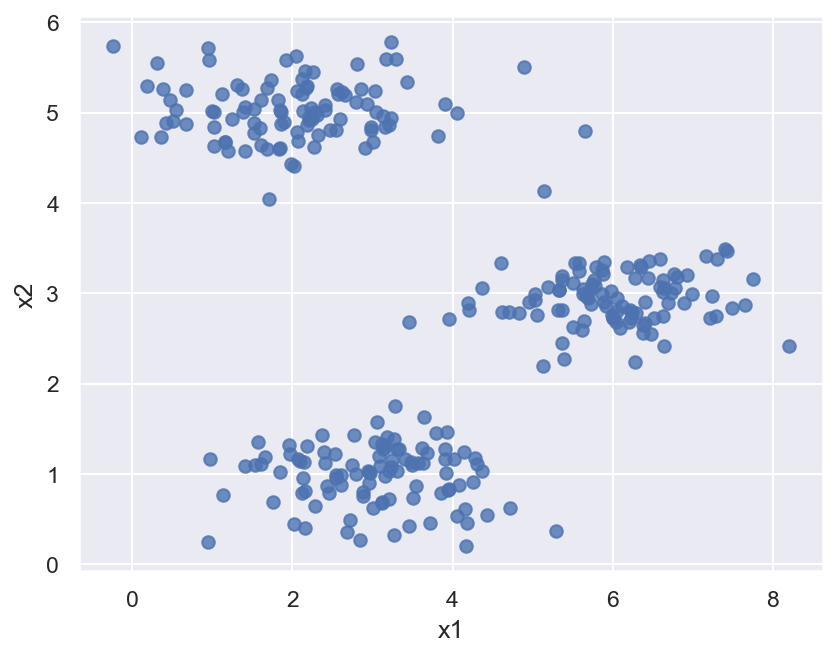

In [164]:
plt.figure(dpi=150)
plt.scatter(x1,x2,color='b',alpha=0.8)
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

In [165]:
#预设聚类簇数k：请观察数据集散点图，预计聚类簇数k
k = 3

In [166]:
#随机选择数据集中k个点作为初始聚类中心
def init_centers(X,k):
    """
    输入：X:数据集(ndarray), k：预设的聚类簇数(int)
    输出：centers：初始化的中心集（建议：元素为ndarray的list)
    可能使用的函数：random.randint
    注意：需保证随机取的样本不重复
    """
    # 获取数据集的样本数量
    num_samples = X.shape[0]
    
    # 随机生成k个不重复的索引
    random_indices = random.sample(range(num_samples), k)
    
    # 使用这些索引从数据集X中选择初始中心点
    centers = [X[i] for i in random_indices] #随机从数据集中选取的3个中心点
    return centers
# centers = init_centers(X, k)
# print(centers)

In [167]:
#向量欧氏距离计算，用于计算每个样本和中心的距离，可用于簇分配和代价函数计算
def distance(v1, v2):
    """
    输入：v1:样本(ndarray), v2:当前对应的中心(ndarray)
    输出：distance:欧氏距离(float/ndarray)
    """
    # 使用numpy的linalg.norm函数计算欧几里得距离
    # distance = np.linalg.norm(v1 - v2)
    diff = v1- v2
    squared_diff = diff[0] ** 2 + diff[1] ** 2
    dist = squared_diff ** 0.5
    distance = np.array(dist) 
    return distance

In [168]:
#将样本分配到距离最近的中心所在的簇
def cluster_assignment(X, centers):
    """
    输入：X:数据集(ndarray), centers：当前中心集（建议：元素为ndarray的list)
    输出：assignment(建议：字典：key为簇标号、value为元素是ndarray的list)
    可能使用的函数：np.argmin
    注意：list和array在某些计算时的转换
    """
    assignment = {}# key为对应的簇（中心），items则代表这个簇包含的点
    for i in range(len(centers)):
        assignment[i] = []
    for x in X:
        distances = []
        for j in range(len(centers)):
            distances.append(distance(x, centers[j]))# 对于每一个x，找到它与所有中心点的距离
        closest = np.argmin(distances) # 找到每一个x最近的中心点
        assignment[closest].append(x) # 将这个点划分到正确的簇中
    return assignment
assignment = cluster_assignment(X, centers)

In [169]:
#代价函数：所有数据点到当前对应中心的欧氏距离之和的平均值
def cost_function(assignment, centers):
    """
    输入：X:数据集(ndarray), centers：当前中心（建议：元素为ndarray的list)
    输出：cost:代价函数值（float/ndarray）
    可能使用的函数：np.argmin
    注意：list和array在使用np函数计算时的转换
    """
    
    cost = []
    num = 0
    sumdis = 0
    for index in assignment.keys():
        for x in assignment[index]:
            sumdis += distance(x, centers[index])#相当于是计算每一个簇包含的所有点到这个中心的距离之和
            num += 1
    cost = sumdis / num
    return cost
cost_function(assignment, centers)

2.3596047105280076

In [170]:
#更新中心,满足停机条件（聚类中心不再改变）时结束更新
def center_update(assignment, centers):
    """
    输入：assignment(建议：字典：key为簇标号、value为元素是ndarray的list), centers：当前中心（建议：元素为ndarray的list)
    输出：new_centers:更新的中心集（建议：元素为ndarray的list), stop：停机条件标识（不停机：0/停机：1）
    可能使用的函数：np.mean
    注意：list和array在使用np函数计算时的转换
    """
    new_centers = []
    for index in assignment.keys():
        points = assignment[index]
        points = np.array(points)
        new_centers.append(np.mean(points, axis = 0)) # 直接算出这些点的平均中心坐标作为簇的中心以减小cost
    new_centers_1 = np.array(new_centers)
    centers_1 = np.array(centers)
    if (new_centers_1 == centers_1).all():
        stop = 1
    else:
        stop = 0
    return new_centers, stop

In [171]:
#聚类可视化
def plot_clustering(assignment, centers, epoch):
    color = ['r', 'b', 'c', 'g', 'k', 'w', 'y', 'm']
    plt.figure(dpi=150)
    for k in range(len(centers)):
        cluster = np.array(assignment[k])
        if len(cluster) == 0:
            continue
        x1 = cluster[:,0]
        x2 = cluster[:,1]
        plt.scatter(x1, x2, c=color[k])
        plt.xlabel('x1')
        plt.ylabel('x2')
    for k in range(len(centers)):
        x1 = centers[k][0]
        x2 = centers[k][1]
        plt.scatter(x1, x2, c='k', marker = '*')
        plt.xlabel('x1')
        plt.ylabel('x2')
    plt.title('epoch'+ str(epoch))
    plt.show()

In [172]:
#kmeans及可视化
def kmeans(X, k, max_epoch, plot=True):
    """
    输入：X:数据集(ndarray), k：预设的聚类簇数(int), max_epoch：最大训练轮数(int), plot:是否可视化（True/False)
    输出：assignment(建议：字典：key为簇标号、value为元素是ndarray的list), cost:最终的代价函数值，用于k-cost曲线的绘制（float/ndarray）
    注意：可视化只考虑了二维数据的情况，如需多维数据可视化请自行修改
    """
    centers = init_centers(X,k)
    stop = 0
    for epoch in range(max_epoch):
        if stop == 0:
            assignment = cluster_assignment(X, centers)
            plot_clustering(assignment, centers, epoch)
            centers, stop = center_update(assignment, centers)
        else:
            break
    cost = cost_function(assignment, centers)
    return assignment, cost

In [173]:
max_epoch = 200 

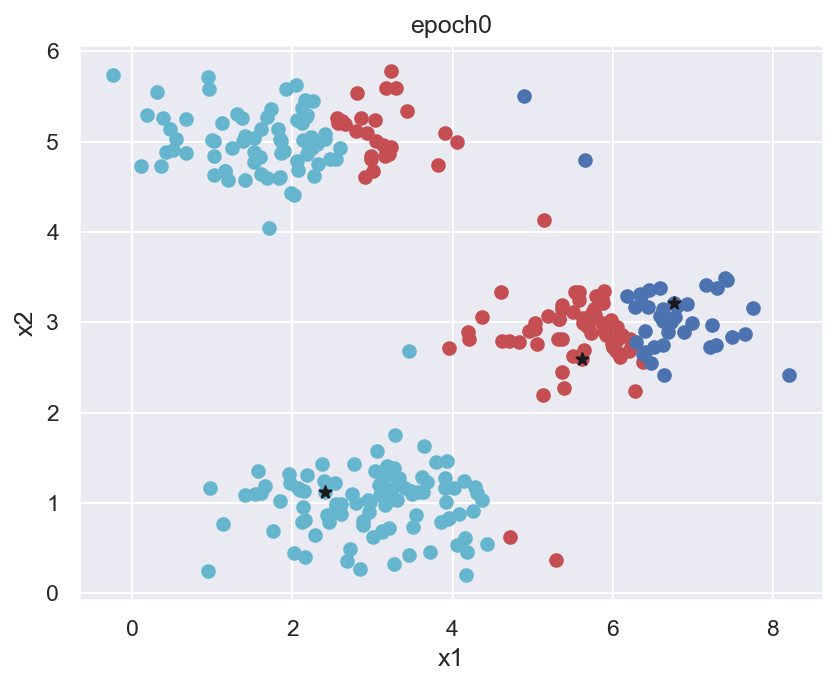

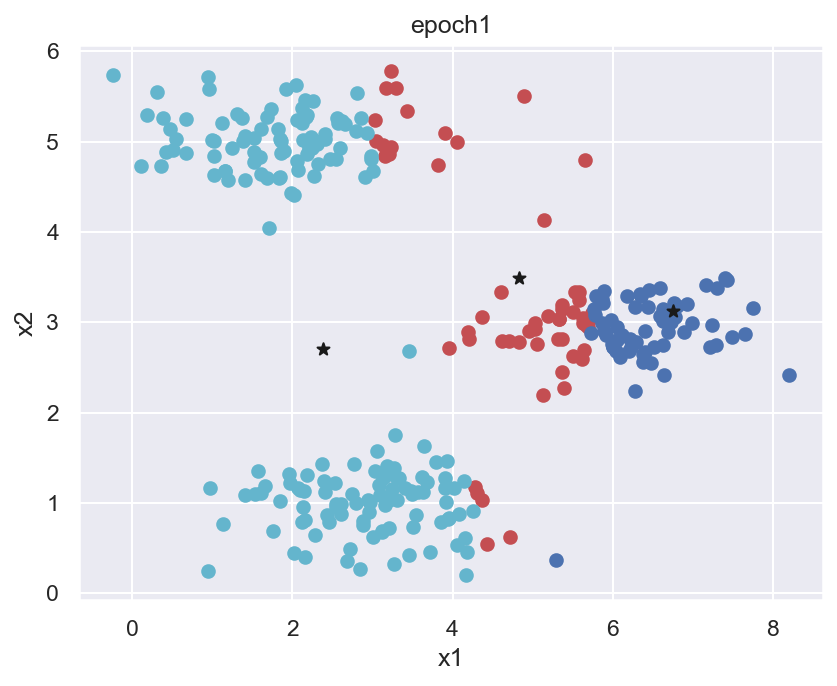

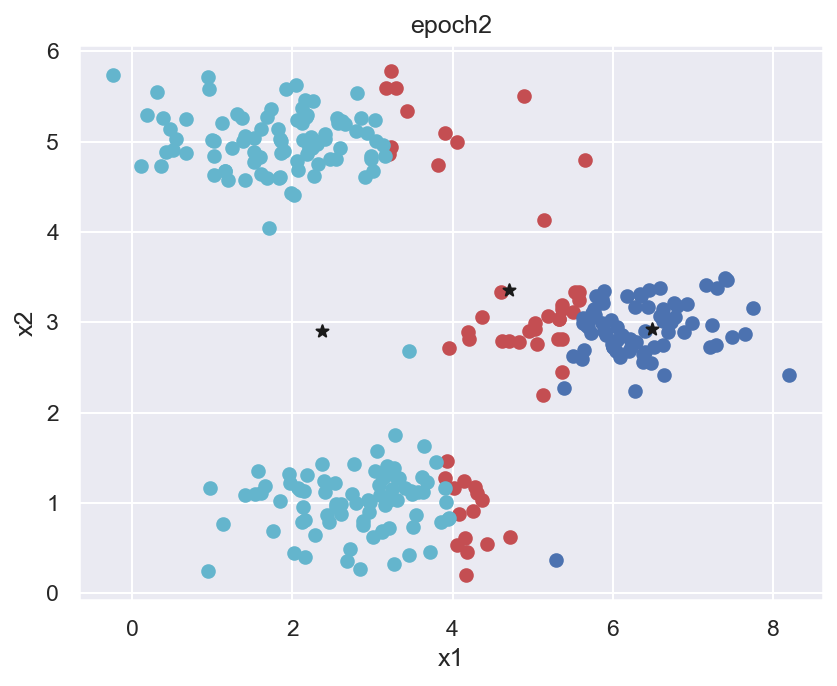

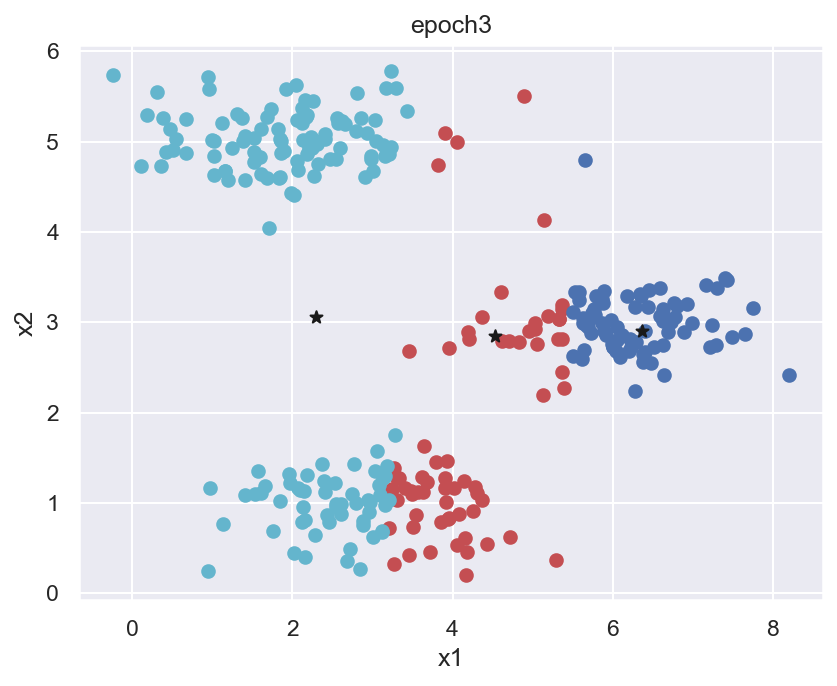

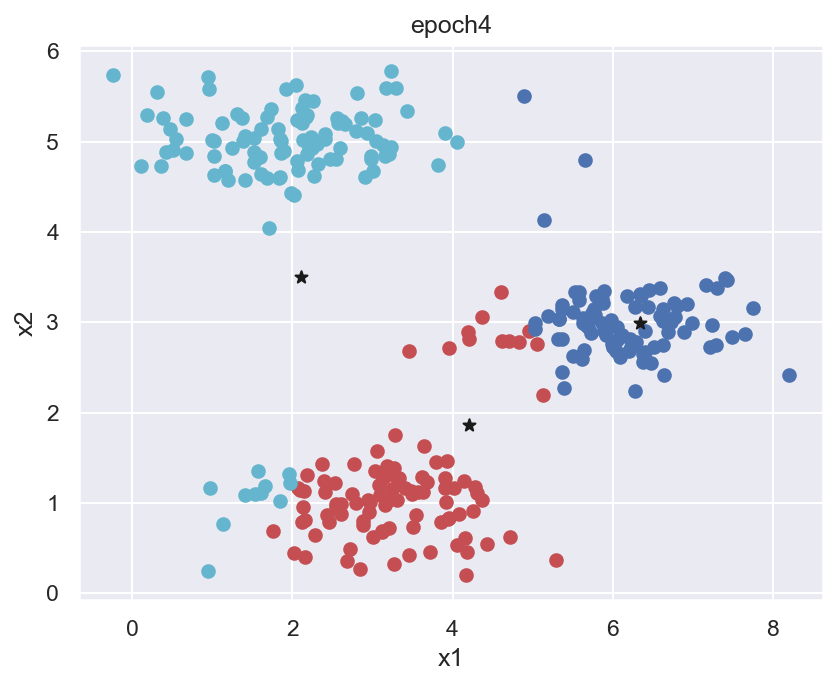

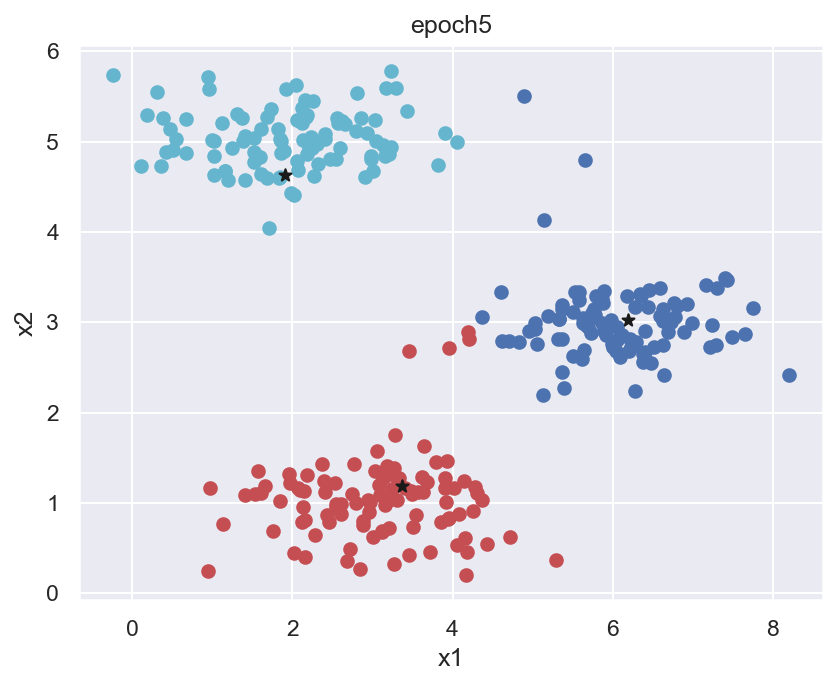

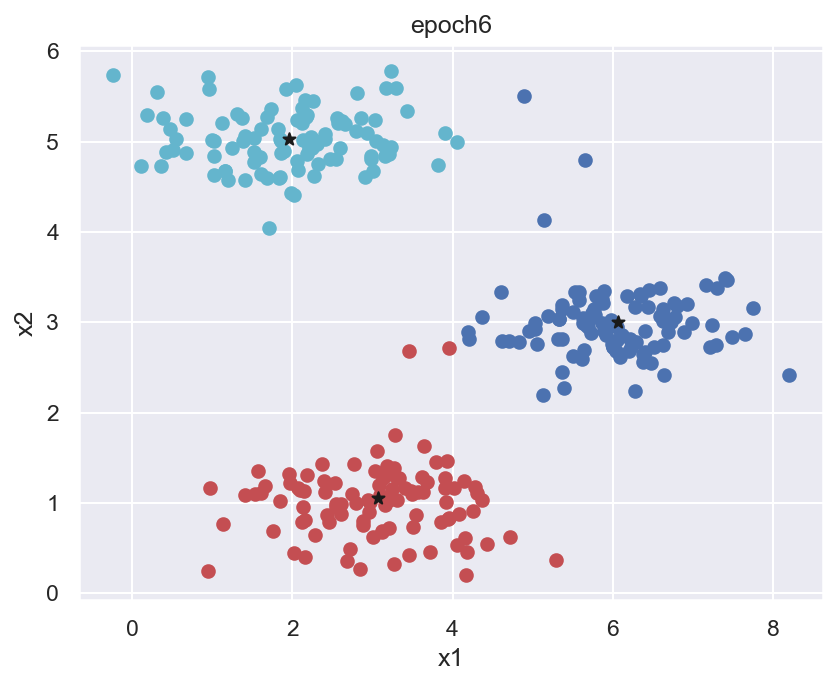

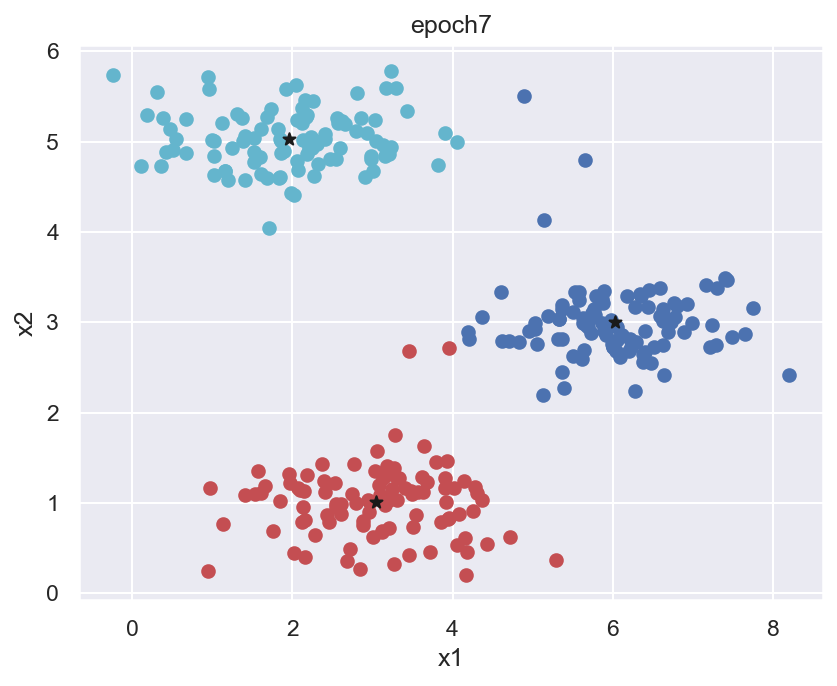

In [174]:
assignment, _ = kmeans(X, k, max_epoch)

<Figure size 960x720 with 0 Axes>

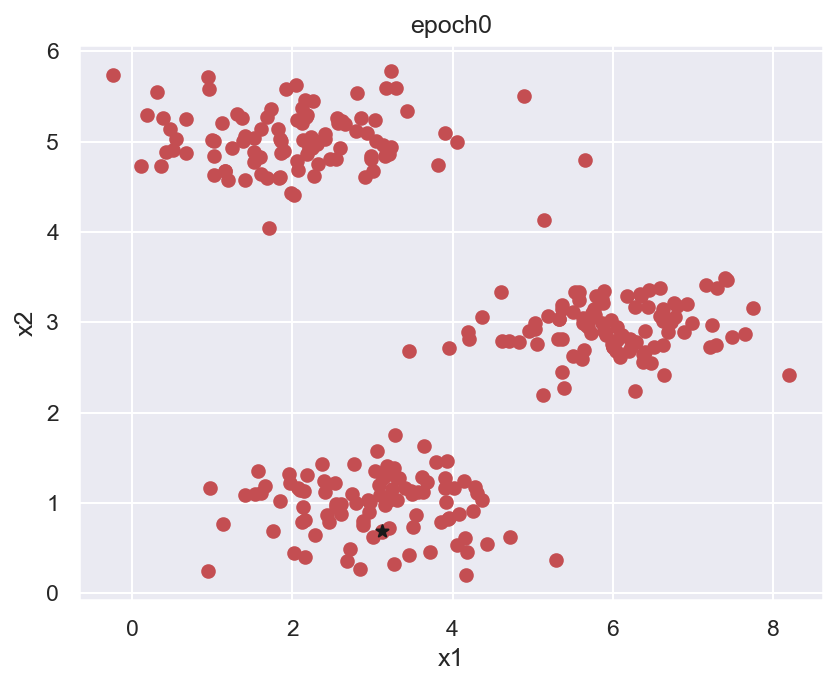

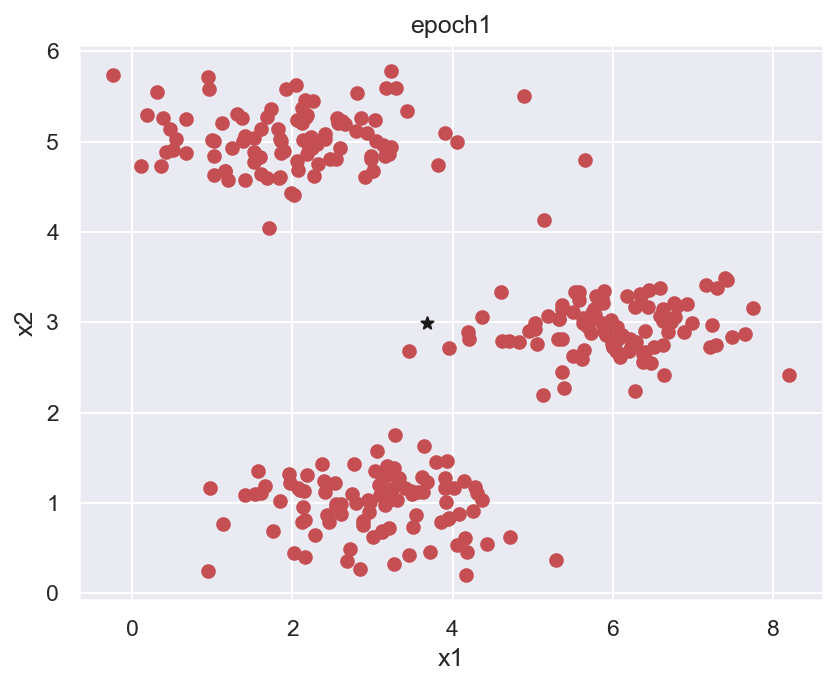

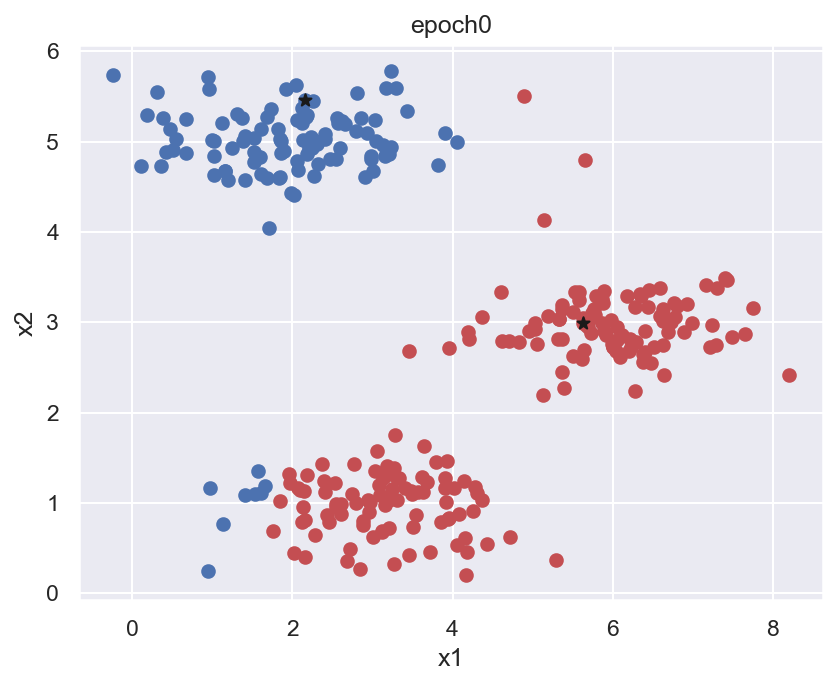

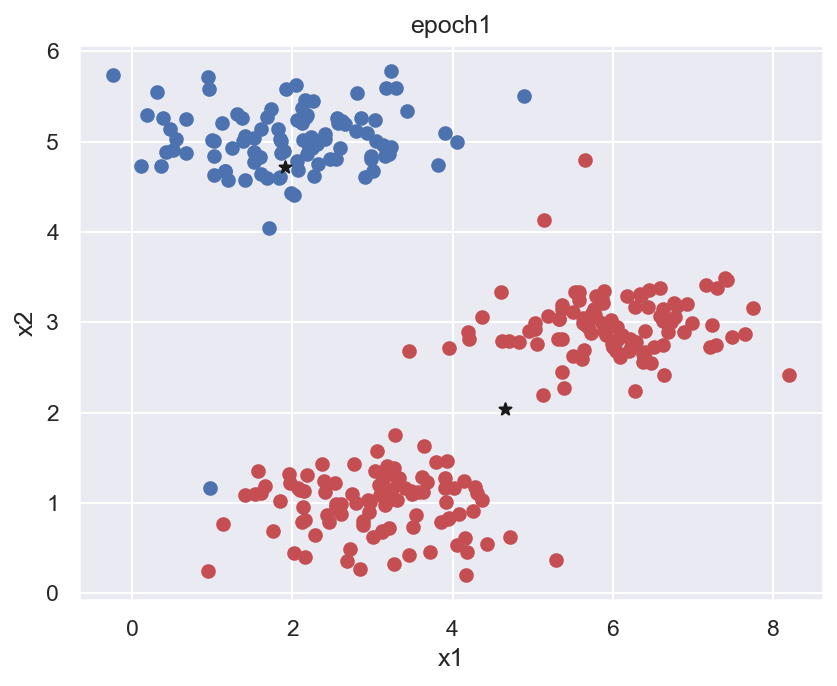

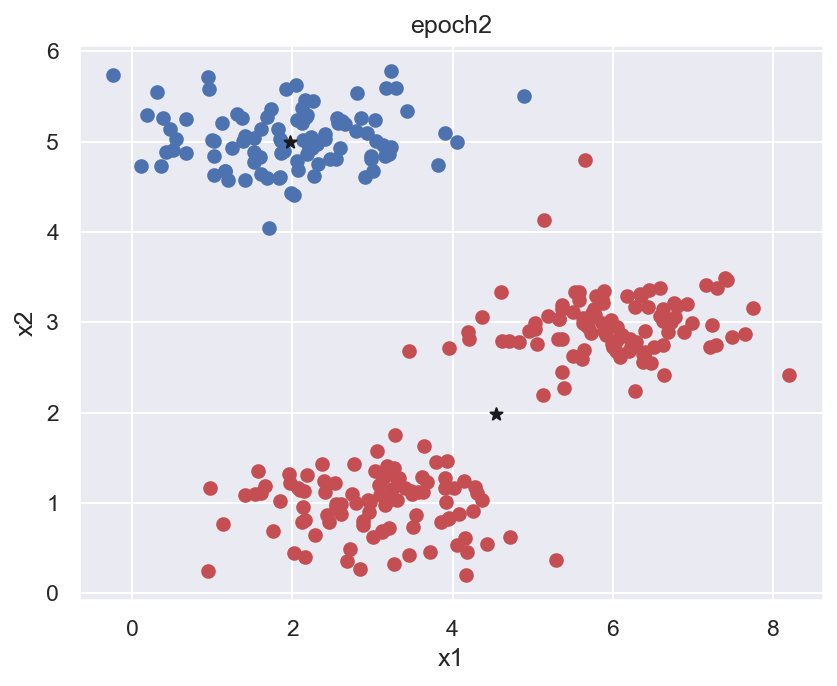

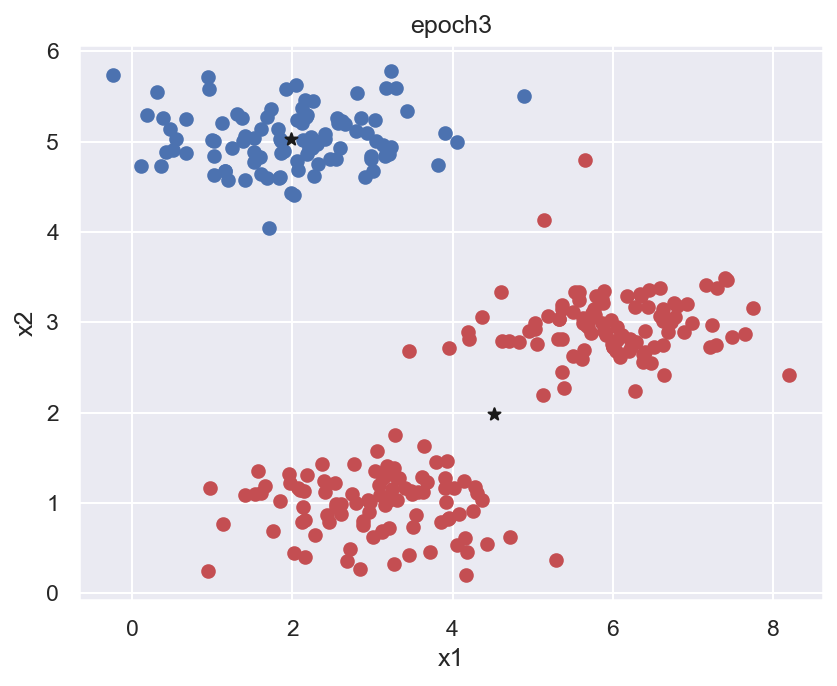

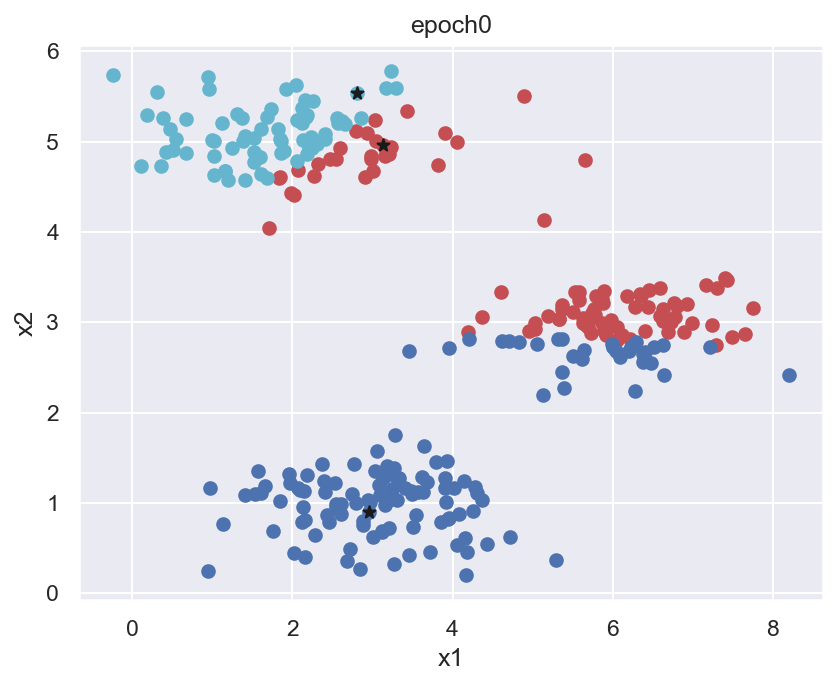

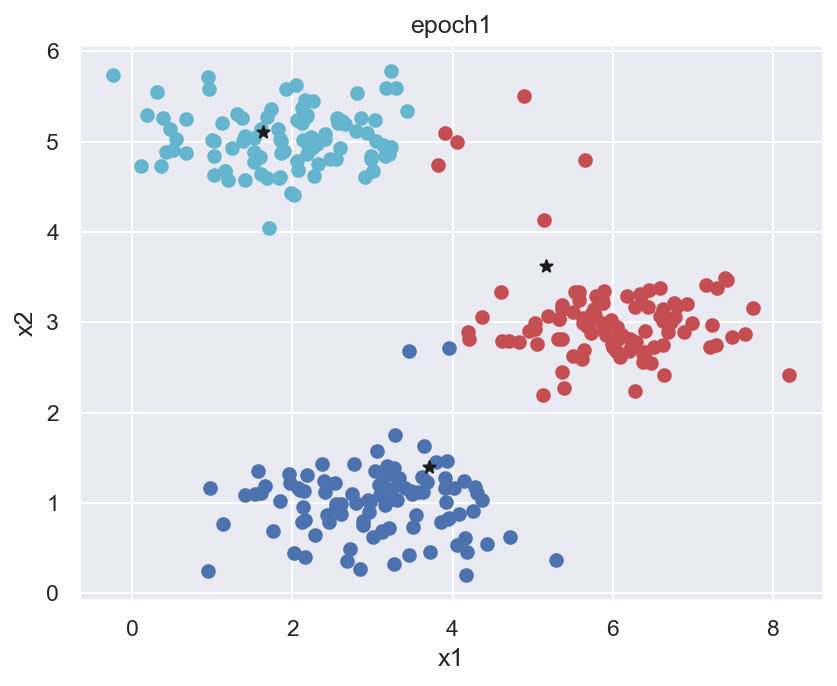

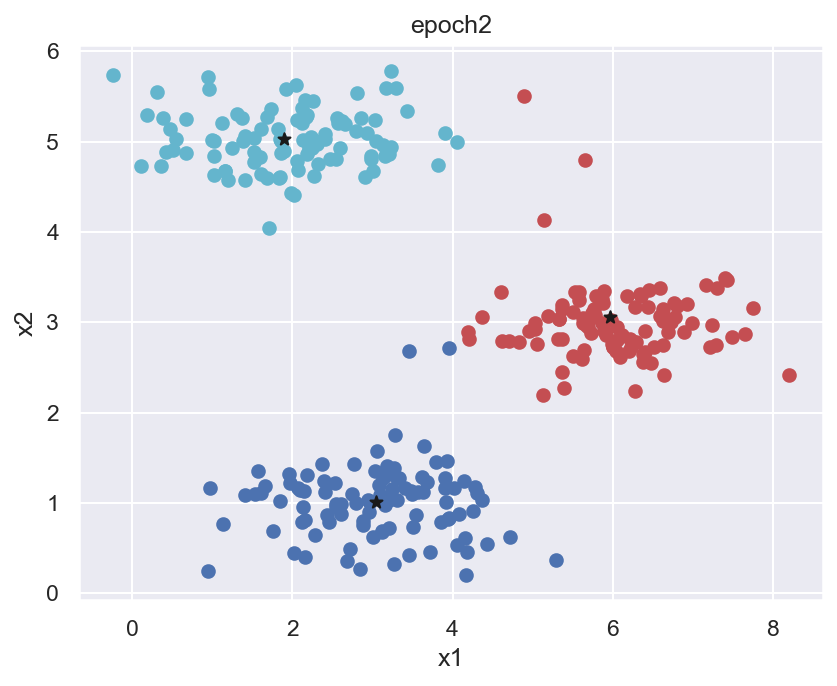

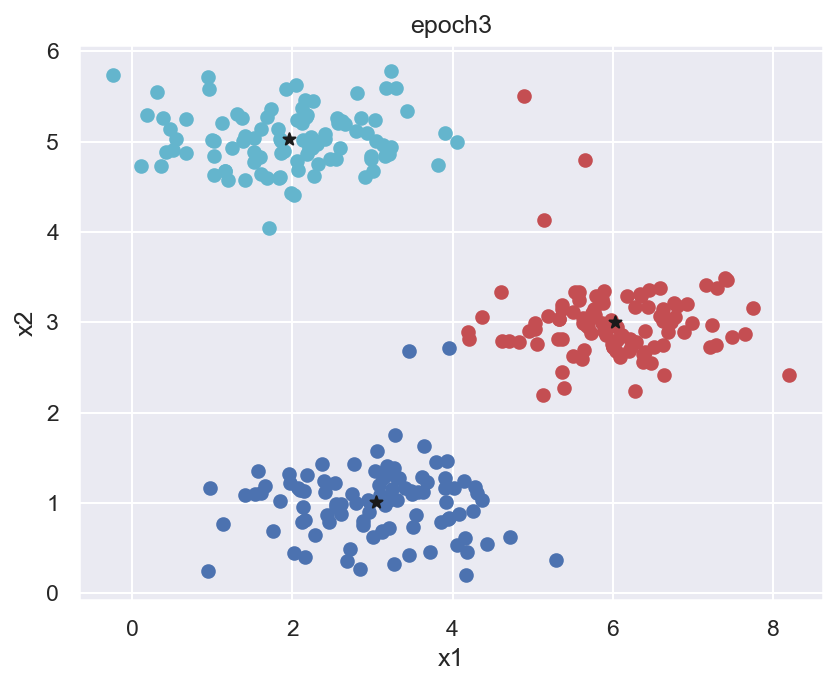

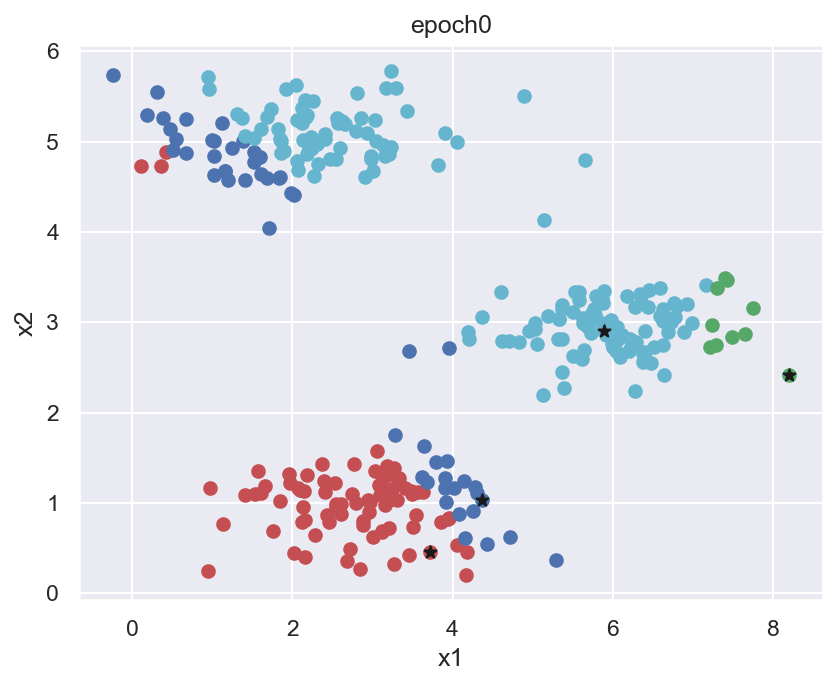

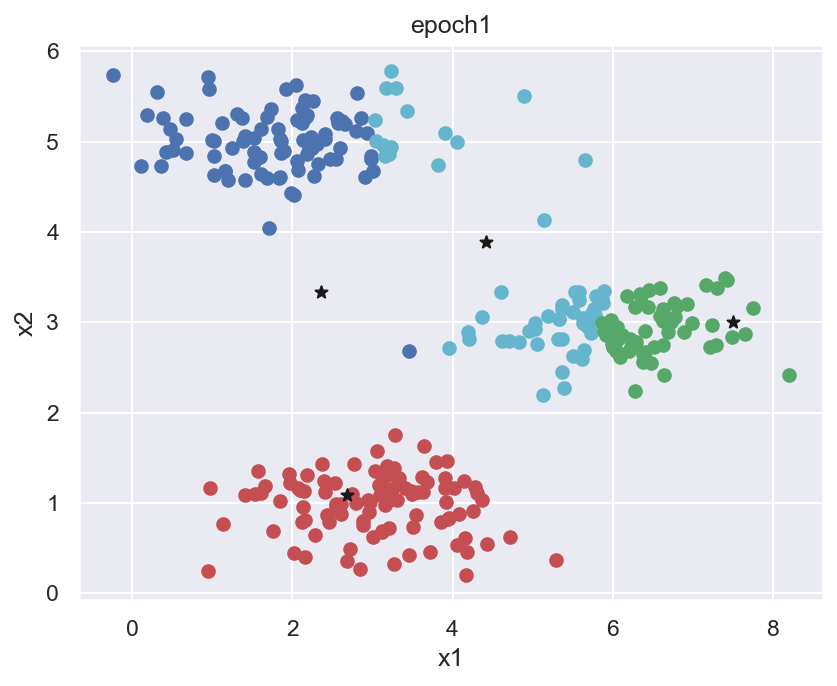

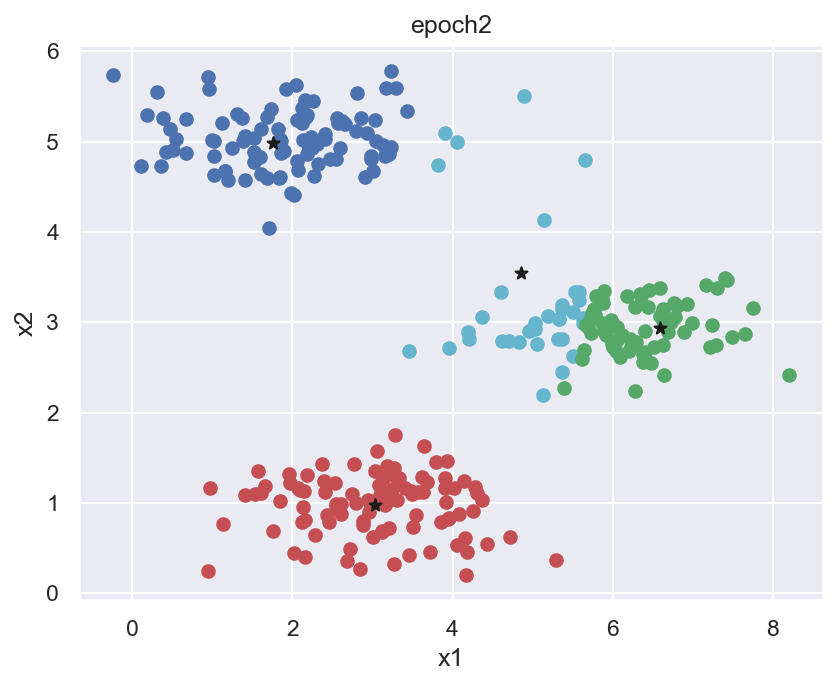

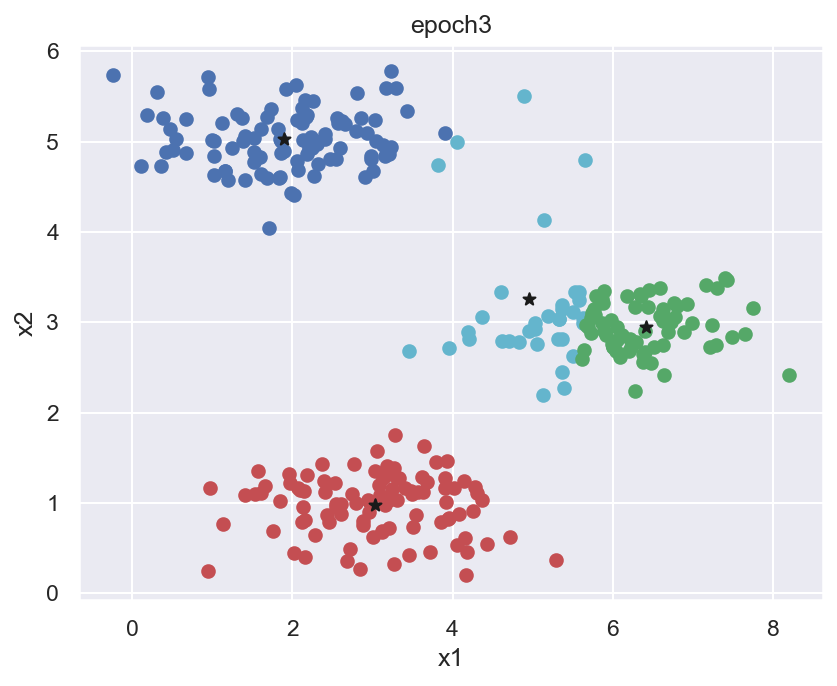

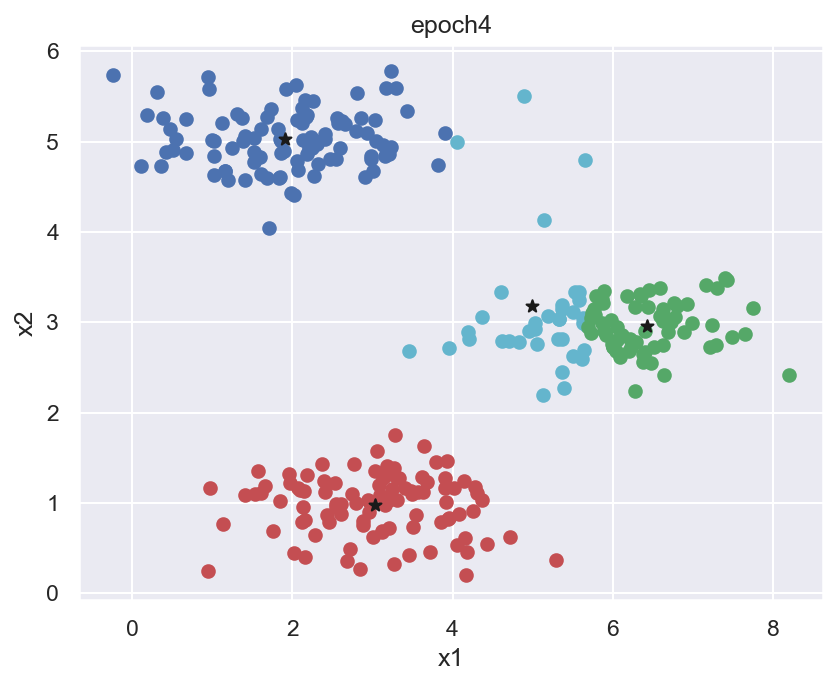

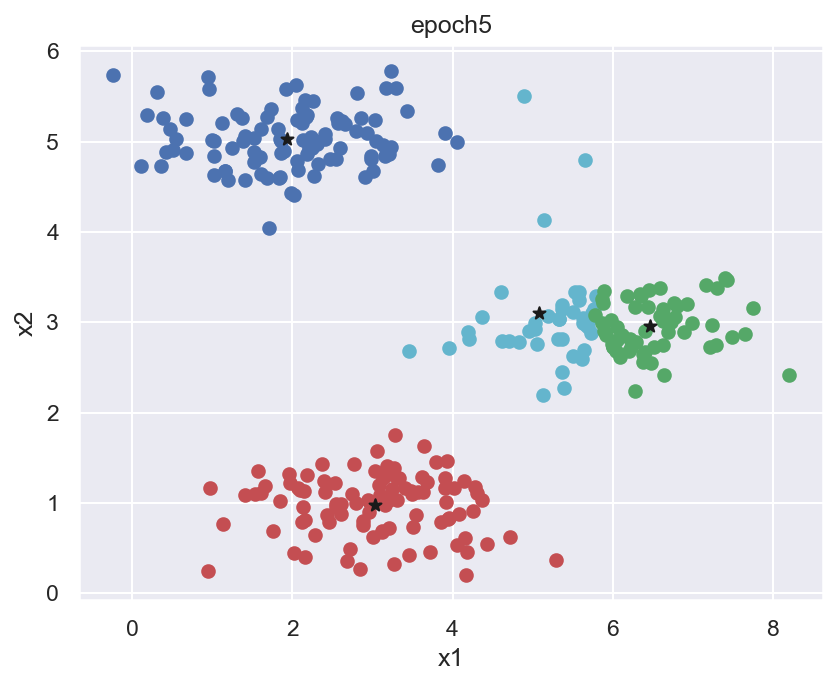

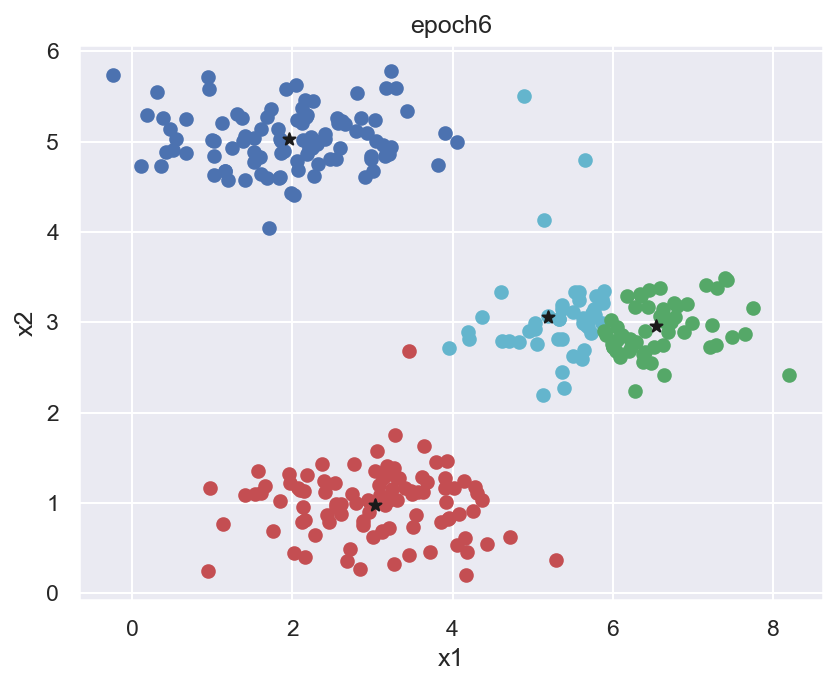

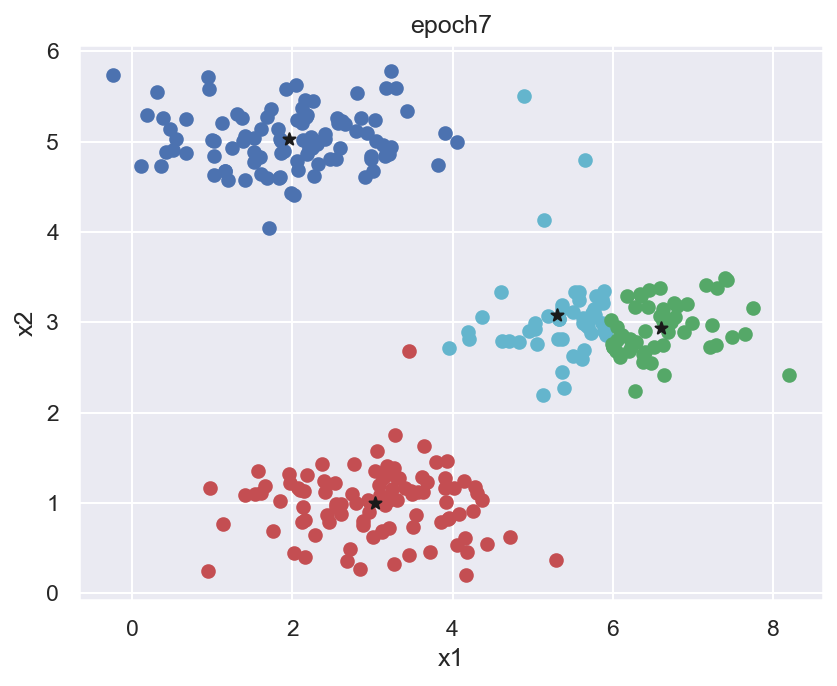

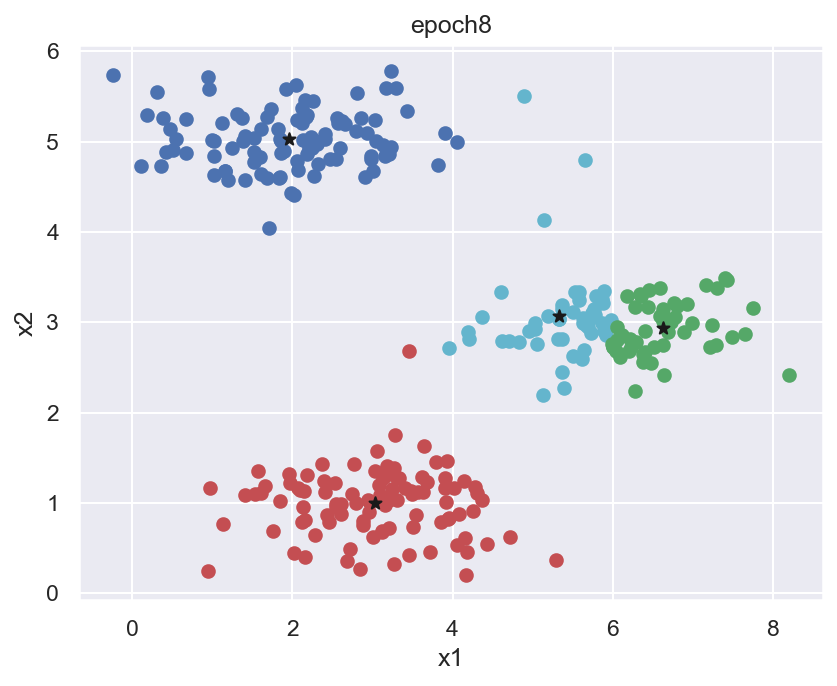

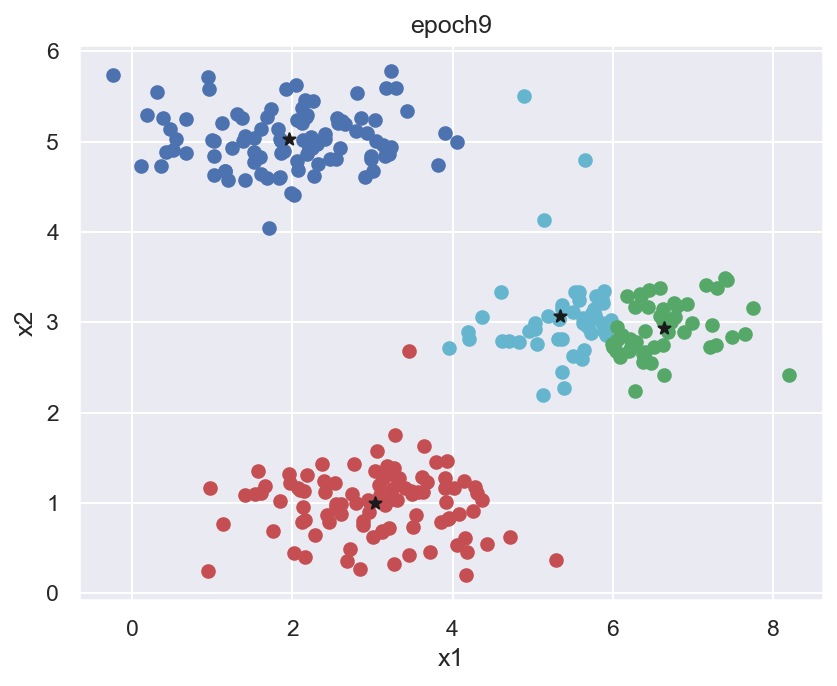

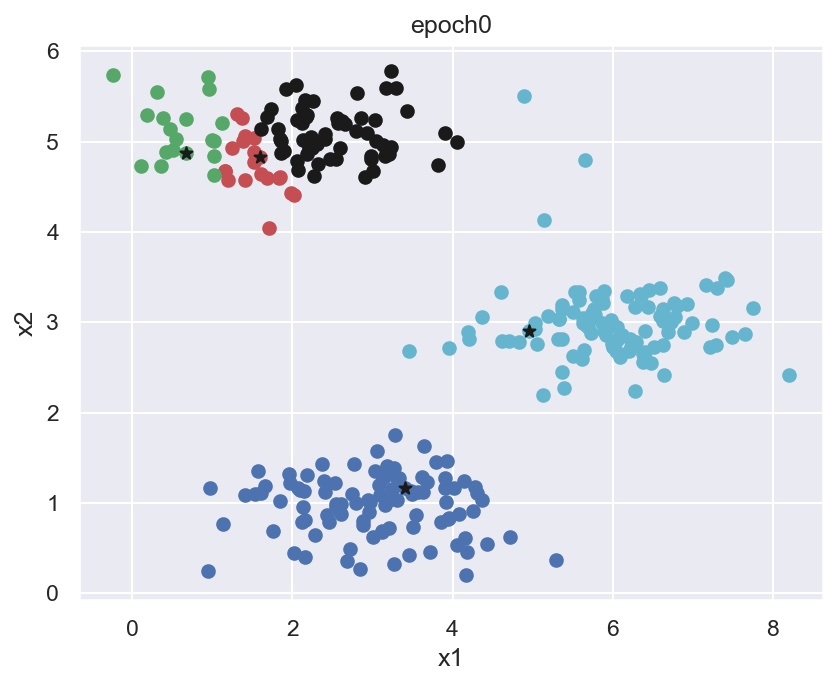

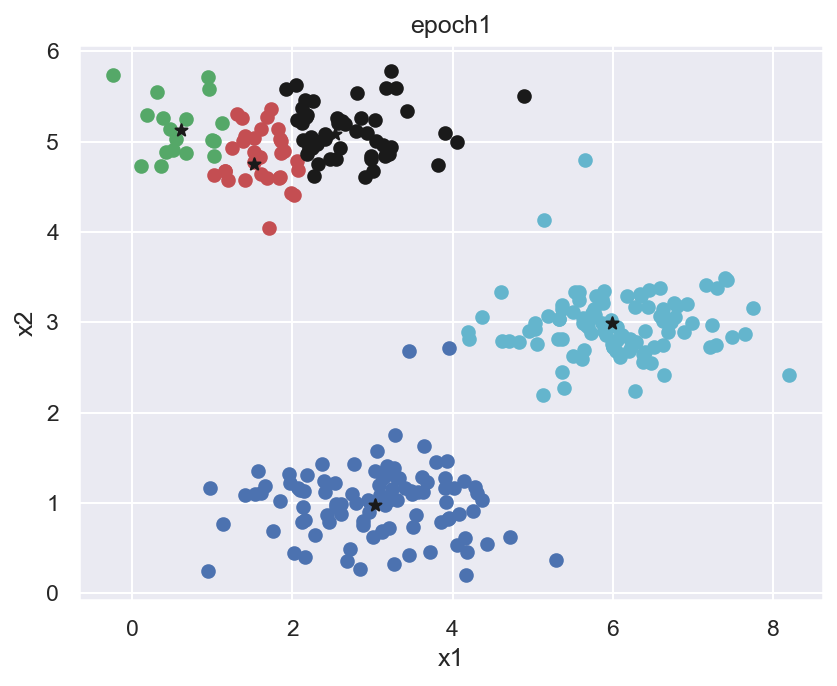

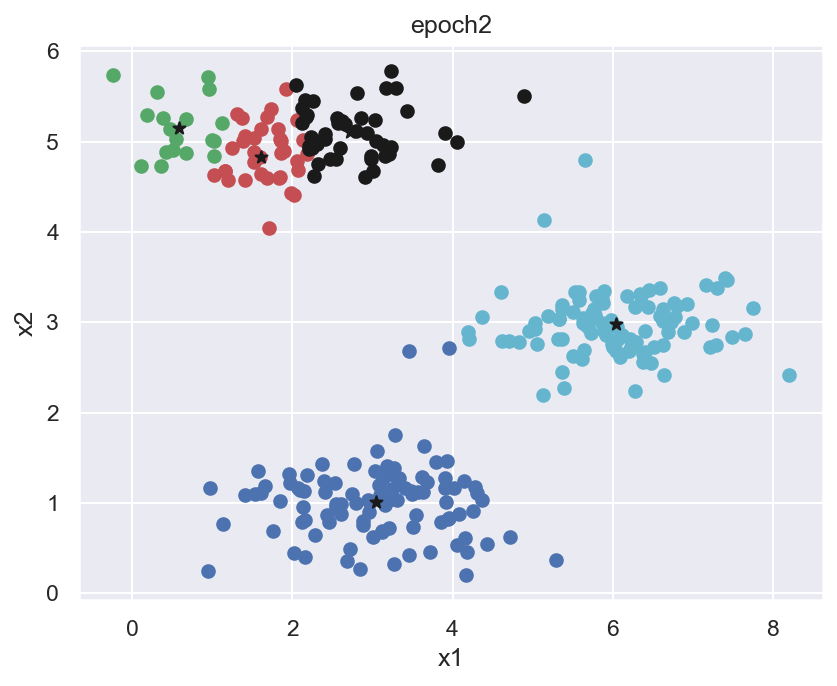

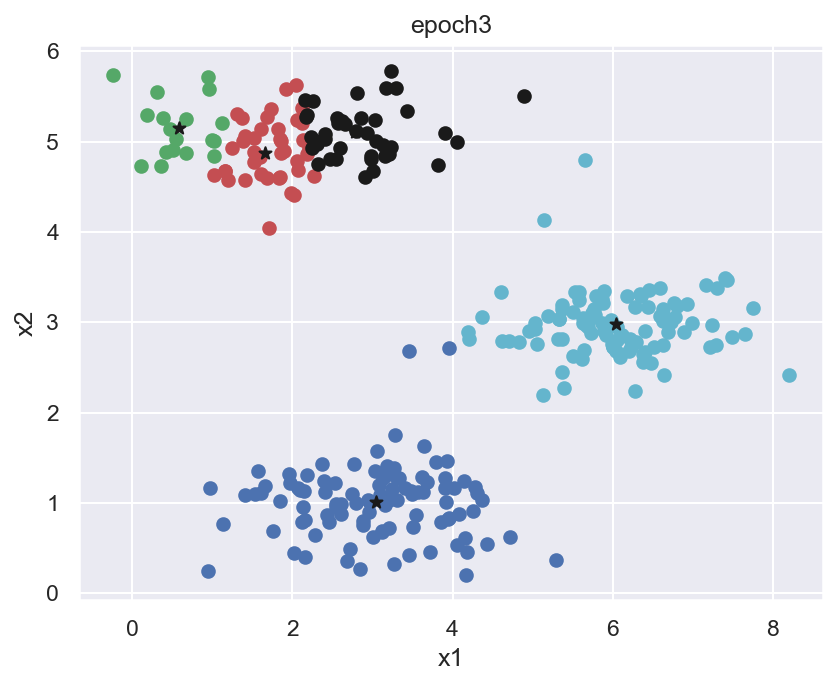

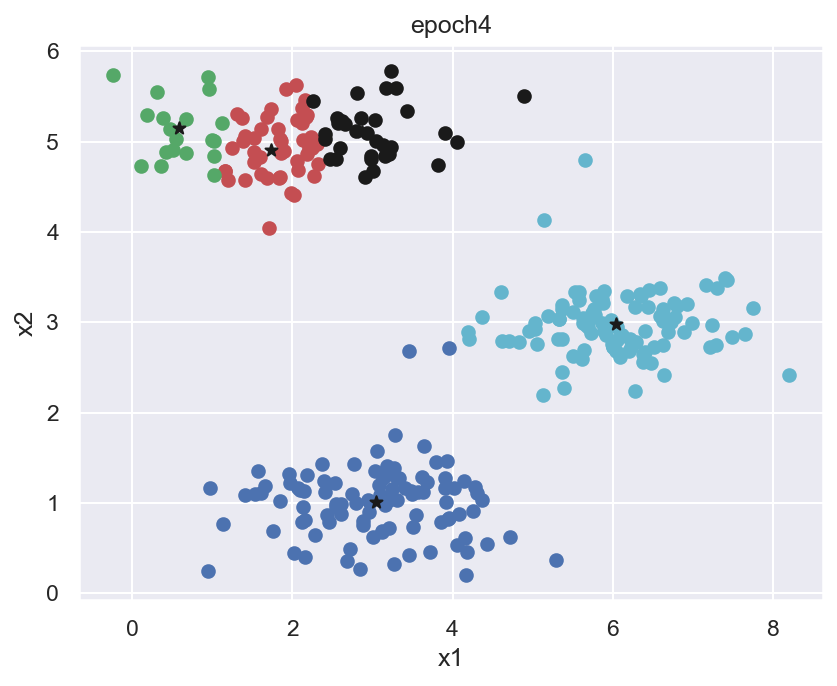

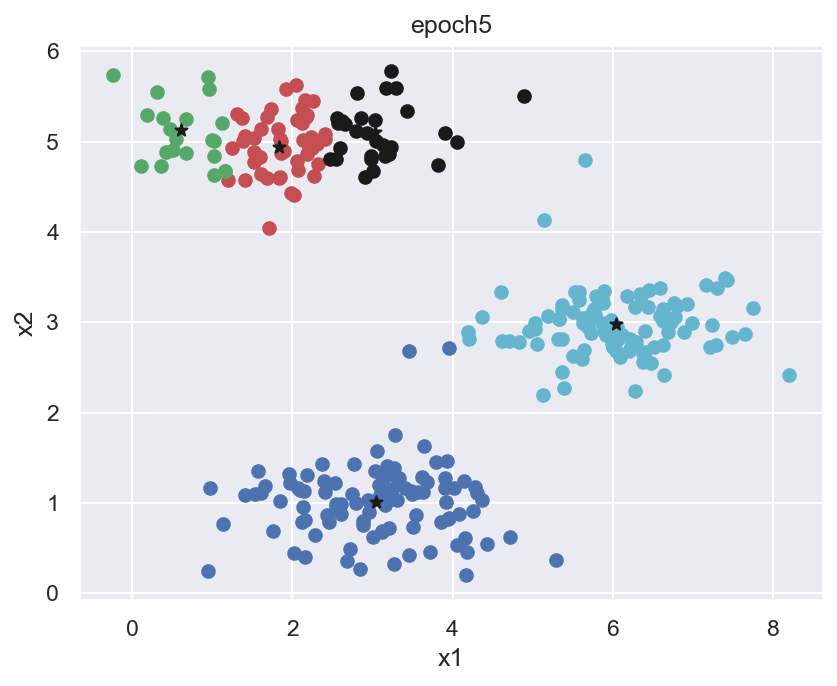

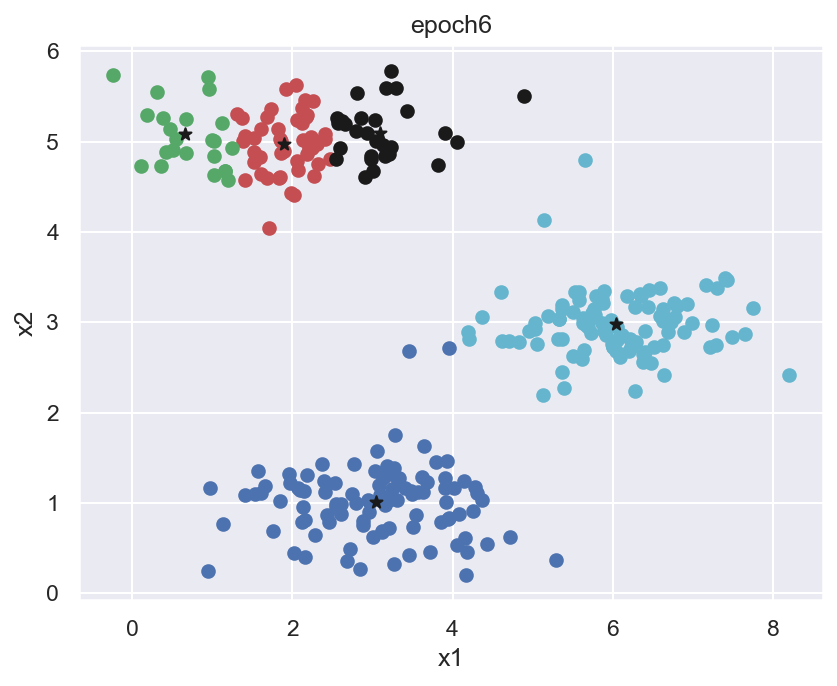

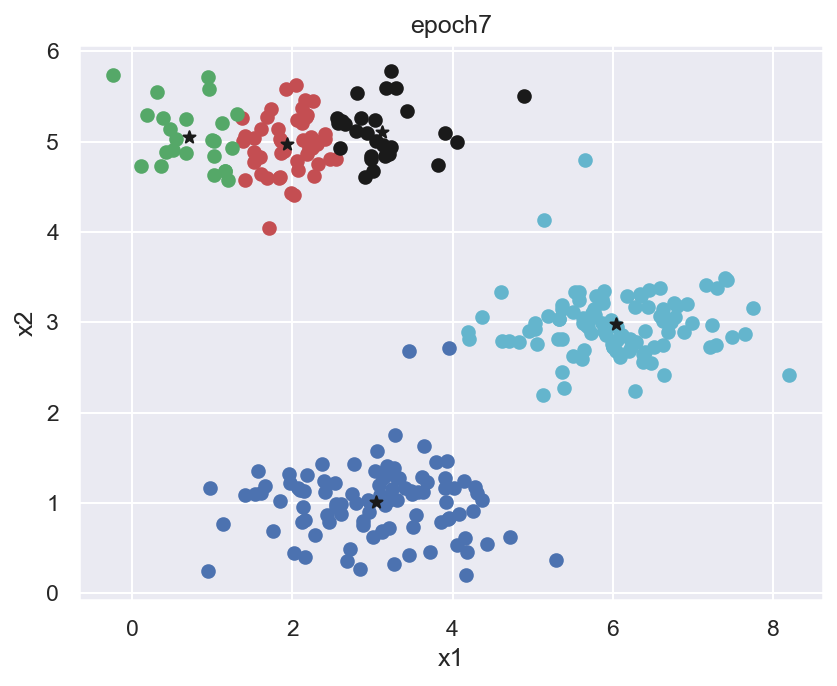

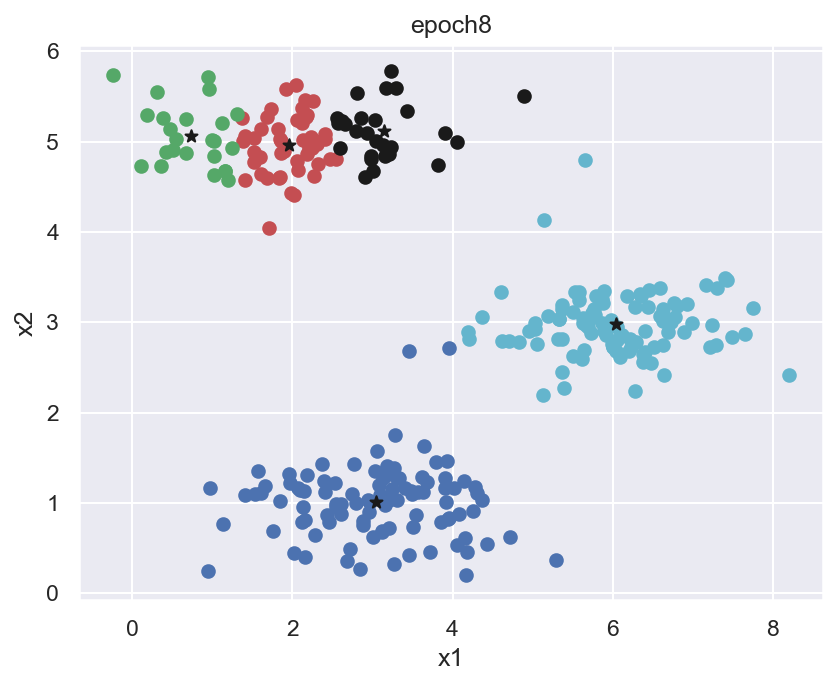

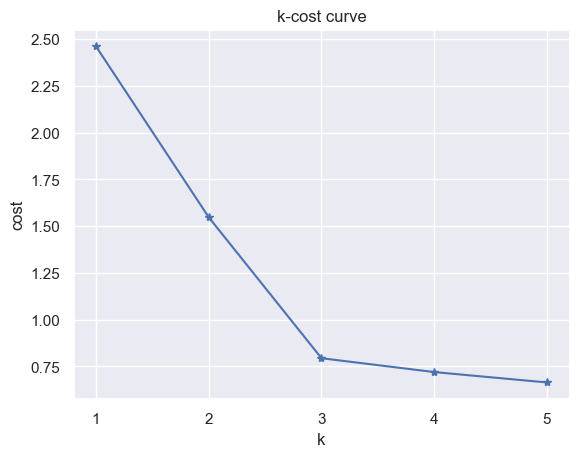

In [175]:
#绘制簇数-代价函数曲线：根据曲线，观察最合适的簇数k的选择
plt.figure(dpi=150)
Cost = []
max_k = 6
for k in range(1, max_k):
    _, cost = kmeans(X, k, max_epoch,False)
    Cost.append(cost)

plt.plot(range(1,max_k), Cost, c='b', marker = '*')
plt.xticks(range(1,max_k))
plt.xlabel('k')
plt.ylabel('cost')
plt.title('k-cost curve')
plt.show()

当k>=3时，cost函数斜率减小，可见之最佳簇数是3